In [1]:
import pandas as pd
import numpy as np

#  plot confusion matrices
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier

import sys
sys.path.insert(1, '../')
from py_oqat.config_algorithms import ACOConfig
from py_oqat.classifier import OQATClassifier

In [2]:
SEED = 42

def pretty_print_confusion_matrix(confusion_matrix):
    for row in confusion_matrix:
        print(row)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    # print(cm)

    df_cm = pd.DataFrame(cm, index = [i for i in classes],
                  columns = [i for i in classes])
    plt.figure(figsize = (7,5))
    sns.heatmap(df_cm, annot=True, cmap=cmap)

    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()



In [3]:
# Read csv file and load it into a numpy array
# df = pd.read_csv('datasets/test2.csv')
df = pd.read_csv('../datasets/hayes_roth.csv')
# df = pd.read_csv('datasets/car.csv')


# Separate features and labels into two dataframes
X = df.drop('class', axis=1)
y = df['class']

# Define the feature type for each column (discrete or continuous)
column_names = X.columns.to_list()
column_types = ['cat', 'cat', 'cat', 'cat']

# transform the dataframes into a numpy array
X = X.values
y = y.values

In [4]:
# Transform the string labels into integers
from sklearn import preprocessing


X = preprocessing.OrdinalEncoder().fit_transform(X)
y = preprocessing.LabelEncoder().fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [5]:
# Balance the training set

print("Before SMOTE")
print(pd.Series(y_train).value_counts())
# smote = SMOTE()
# X_train, y_train = smote.fit_resample(X_train, y_train)
# print("After SMOTE")
# print(pd.Series(y_train).value_counts())

Before SMOTE
1    43
0    39
2    23
dtype: int64


Decision Tree
[8 4 0]
[2 6 0]
[0 0 7]
Score:  0.7777777777777778


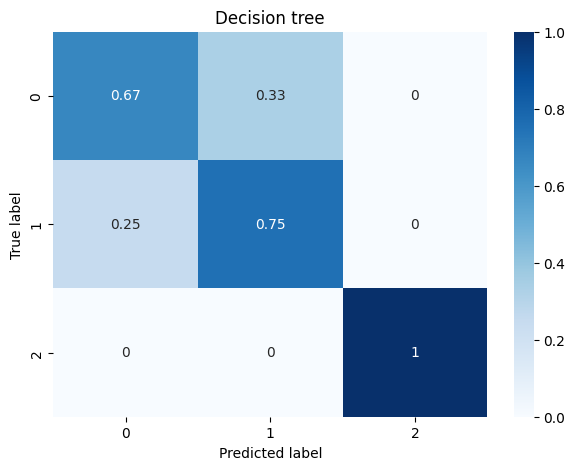

In [6]:
# Run a classification tree algorithm from sklearn
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
cm_tree = confusion_matrix(y_test, y_pred_tree)
print("Decision Tree")
pretty_print_confusion_matrix(cm_tree)
print("Score: ", tree_model.score(X_test, y_test))
plot_confusion_matrix(cm_tree, classes=['0', '1', '2'], normalize=True, title='Decision tree')
# text_repr = tree.export_text(tree_model)
# print(text_repr)

In [7]:
# # Run the OQAT algorithm
aco_config = ACOConfig(algorithm="vertex-ac", cycles=20, ants=10, alpha=1, rho=0.99, tau_max=6., tau_min=0.01)
classifier = OQATClassifier(collision_strategy="best_score", null_strategy="weighted", heuristic="aco", heuristic_config=aco_config)
classifier.fit(X_train, y_train, column_names, column_types)
print(classifier.model)

Model for class 0 created
Score: 0.71875
Model for class 1 created
Score: 0.875
Model for class 2 created
Score: 1.0
{0: {'oqat_model': (([marital=0.00] ∨ [marital=2.00] ∨ [age=0.00]) ∧ ([marital=1.00] ∨ [education=0.00] ∨ [age=0.00] ∨ [age=2.00]) ∧ ([marital=2.00] ∨ [hobby=2.00] ∨ [hobby=0.00] ∨ [education=0.00] ∨ [education=1.00] ∨ [age=1.00]) ∧ ([age=1.00] ∨ [age=2.00] ∨ [marital=0.00] ∨ [marital=2.00] ∨ [hobby=0.00] ∨ [hobby=1.00] ∨ [education=2.00] ∨ [education=0.00]) ∧ ([education=2.00] ∨ [education=1.00] ∨ [hobby=1.00] ∨ [hobby=2.00] ∨ [marital=0.00] ∨ [marital=1.00] ∨ [age=2.00] ∨ [age=0.00]) ∧ ([marital=2.00] ∨ [marital=1.00] ∨ [age=2.00] ∨ [age=1.00] ∨ [hobby=1.00] ∨ [education=2.00] ∨ [education=1.00]) ∧ ([marital=1.00] ∨ [marital=2.00] ∨ [education=2.00] ∨ [education=0.00] ∨ [age=1.00] ∨ [age=0.00] ∨ [hobby=1.00] ∨ [hobby=2.00]) ∧ ([marital=0.00] ∨ [marital=2.00] ∨ [education=0.00] ∨ [education=1.00] ∨ [age=2.00] ∨ [age=1.00] ∨ [hobby=2.00] ∨ [hobby=1.00]) ∧ ([marital=1.00]

In [8]:
classifier.collision_strategy = "None"
classifier.null_strategy = "None"
y_pred_set = classifier.predict(X_test, column_names)
print(y_pred_set)

[1, 1, -1, 0, 0, 1, 1, 0, 2, 0, 0, [0, 1], 0, 2, 2, 1, [0, 1], 1, 1, [0, 2], 1, 0, 0, 2, [1, 2], -1, [0, 2]]


[1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 0, 1, 0, 2, 2, 1, 1, 1, 1, 2, 1, 0, 0, 2, 2, 0, 2]
[8, 4, 0]
[2, 6, 0]
[0, 0, 7]
Score:  0.7777777777777778


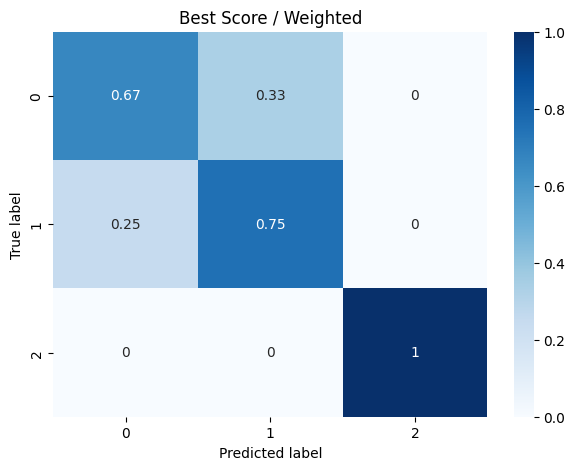

In [9]:
classifier.collision_strategy = "best_score"
classifier.null_strategy = "weighted"
y_pred_bs_w = classifier.predict(X_test, column_names)
print(y_pred_bs_w)
cm_bs_w = classifier.confusion_matrix(y_pred_bs_w, y_test)
pretty_print_confusion_matrix(cm_bs_w)
print("Score: ", classifier.score(y_pred_bs_w, y_test))
plot_confusion_matrix(np.array(cm_bs_w), classes=['0', '1', '2'], normalize=True, title='Best Score / Weighted')

[1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 0, 1, 0, 2, 2, 1, 1, 1, 1, 2, 1, 0, 0, 2, 2, 1, 2]
[7, 5, 0]
[2, 6, 0]
[0, 0, 7]
Score:  0.7407407407407407


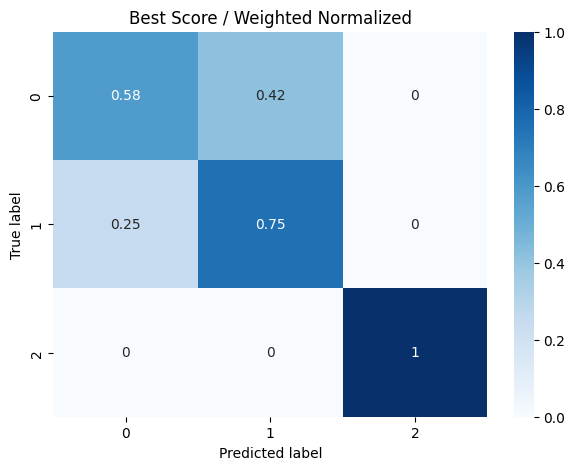

In [10]:
classifier.collision_strategy = "best_score"
classifier.null_strategy = "weighted_normalized"
y_pred_bs_wn = classifier.predict(X_test, column_names)
print(y_pred_bs_wn)
cm_bs_wn = classifier.confusion_matrix(y_pred_bs_wn, y_test)
pretty_print_confusion_matrix(cm_bs_wn)
print("Score: ", classifier.score(y_pred_bs_wn, y_test))
plot_confusion_matrix(np.array(cm_bs_wn), classes=['0', '1', '2'], normalize=True, title='Best Score / Weighted Normalized')

[1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 0, 1, 0, 2, 2, 1, 1, 1, 1, 2, 1, 0, 0, 2, 2, 1, 2]
[7, 5, 0]
[2, 6, 0]
[0, 0, 7]
Score:  0.7407407407407407


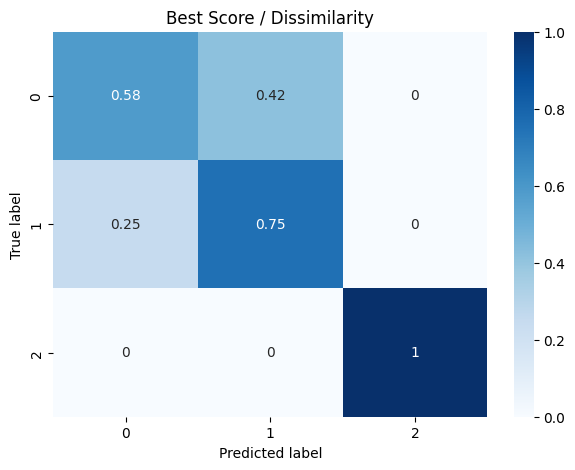

In [11]:
classifier.collision_strategy = "best_score"
classifier.null_strategy = "dissimilarity"
y_pred_bs_d = classifier.predict(X_test, column_names)
print(y_pred_bs_d)
cm_bs_d = classifier.confusion_matrix(y_pred_bs_d, y_test)
pretty_print_confusion_matrix(cm_bs_d)
print("Score: ", classifier.score(y_pred_bs_d, y_test))
plot_confusion_matrix(np.array(cm_bs_d), classes=['0', '1', '2'], normalize=True, title='Best Score / Dissimilarity')

[1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 2, 2, 1, 0, 1, 1, 0, 1, 0, 0, 2, 2, 0, 0]
[8, 4, 0]
[4, 4, 0]
[2, 0, 5]
Score:  0.6296296296296297


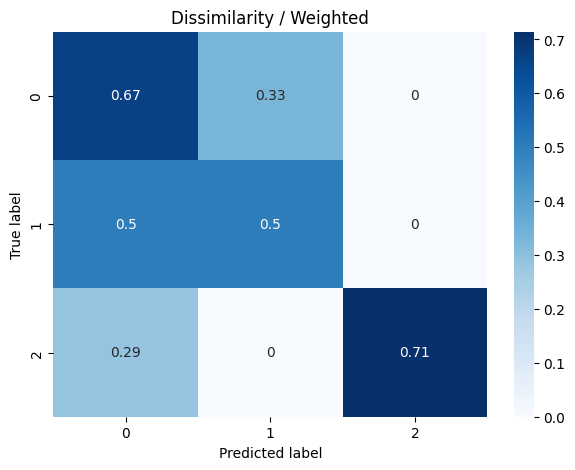

In [12]:
classifier.collision_strategy = "dissimilarity"
classifier.null_strategy = "weighted"
y_pred_d_w = classifier.predict(X_test, column_names)
print(y_pred_d_w)
cm_d_w = classifier.confusion_matrix(y_pred_d_w, y_test)
pretty_print_confusion_matrix(cm_d_w)
print("Score: ", classifier.score(y_pred_d_w, y_test))
plot_confusion_matrix(np.array(cm_d_w), classes=['0', '1', '2'], normalize=True, title='Dissimilarity / Weighted')

[1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 2, 2, 1, 0, 1, 1, 0, 1, 0, 0, 2, 2, 1, 0]
[7, 5, 0]
[4, 4, 0]
[2, 0, 5]
Score:  0.5925925925925926


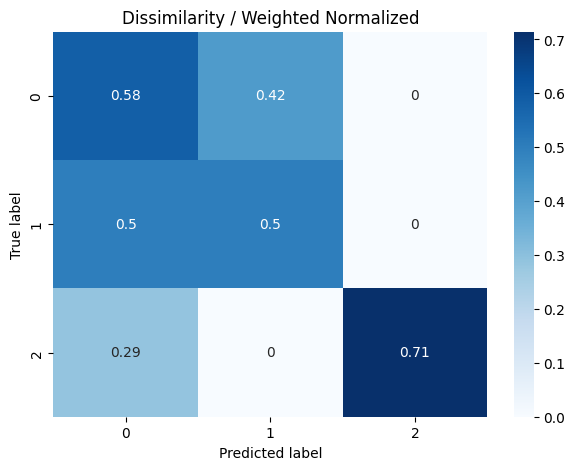

In [13]:
classifier.collision_strategy = "dissimilarity"
classifier.null_strategy = "weighted_normalized"
y_pred_d_wn = classifier.predict(X_test, column_names)
print(y_pred_d_wn)
cm_d_wn = classifier.confusion_matrix(y_pred_d_wn, y_test)
pretty_print_confusion_matrix(cm_d_wn)
print("Score: ", classifier.score(y_pred_d_wn, y_test))
plot_confusion_matrix(np.array(cm_d_wn), classes=['0', '1', '2'], normalize=True, title='Dissimilarity / Weighted Normalized')

[1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 2, 2, 1, 0, 1, 1, 0, 1, 0, 0, 2, 2, 1, 0]
[7, 5, 0]
[4, 4, 0]
[2, 0, 5]
Score:  0.7407407407407407


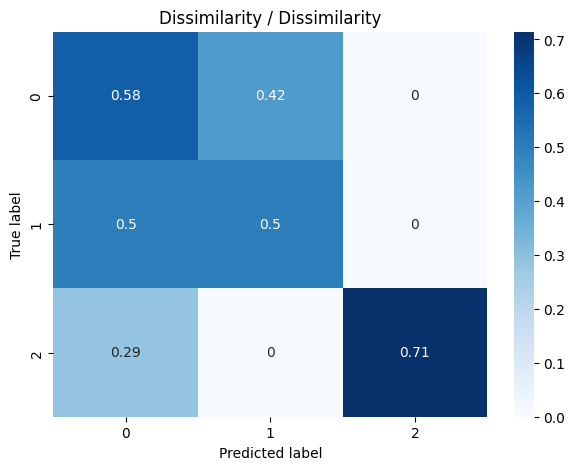

In [14]:
classifier.collision_strategy = "dissimilarity"
classifier.null_strategy = "dissimilarity"
y_pred_d_d = classifier.predict(X_test, column_names)
print(y_pred_d_d)
cm_d_d = classifier.confusion_matrix(y_pred_d_d, y_test)
pretty_print_confusion_matrix(cm_d_d)
print("Score: ", classifier.score(y_pred_bs_d, y_test))
plot_confusion_matrix(np.array(cm_d_d), classes=['0', '1', '2'], normalize=True, title='Dissimilarity / Dissimilarity')

In [15]:

for learning_class, model in classifier.model.items():
    print(f'Class: {learning_class}')
    print(f'Score: {model["score"]}')
    for i, clause in enumerate(model['oqat_model'].model.clauses):
        print(f'\t{model["cnf_weights"][i]: ^4} Clause: {clause}')

print(f'    X           y_test   bs / w    bs / wn   bs / d      d / w    d / wn    d / d   sets')
for i in range(len(y_test)):
    print(X_test[i], f'{y_test[i]: ^9}', f'{y_pred_bs_w[i]: ^9}', f'{y_pred_bs_wn[i]: ^9}', f'{y_pred_bs_d[i]: ^9}', f'{y_pred_d_w[i]: ^9}', f'{y_pred_d_wn[i]: ^9}', f'{y_pred_d_d[i]: ^9}', f'{y_pred_set[i]}')

Class: 0
Score: 0.71875
	 18  Clause: ([marital=0.00] ∨ [marital=2.00] ∨ [age=0.00])
	 10  Clause: ([marital=1.00] ∨ [education=0.00] ∨ [age=0.00] ∨ [age=2.00])
	 3   Clause: ([marital=2.00] ∨ [hobby=2.00] ∨ [hobby=0.00] ∨ [education=0.00] ∨ [education=1.00] ∨ [age=1.00])
	 2   Clause: ([age=1.00] ∨ [age=2.00] ∨ [marital=0.00] ∨ [marital=2.00] ∨ [hobby=0.00] ∨ [hobby=1.00] ∨ [education=2.00] ∨ [education=0.00])
	 2   Clause: ([education=2.00] ∨ [education=1.00] ∨ [hobby=1.00] ∨ [hobby=2.00] ∨ [marital=0.00] ∨ [marital=1.00] ∨ [age=2.00] ∨ [age=0.00])
	 2   Clause: ([marital=2.00] ∨ [marital=1.00] ∨ [age=2.00] ∨ [age=1.00] ∨ [hobby=1.00] ∨ [education=2.00] ∨ [education=1.00])
	 1   Clause: ([marital=1.00] ∨ [marital=2.00] ∨ [education=2.00] ∨ [education=0.00] ∨ [age=1.00] ∨ [age=0.00] ∨ [hobby=1.00] ∨ [hobby=2.00])
	 2   Clause: ([marital=0.00] ∨ [marital=2.00] ∨ [education=0.00] ∨ [education=1.00] ∨ [age=2.00] ∨ [age=1.00] ∨ [hobby=2.00] ∨ [hobby=1.00])
	 2   Clause: ([marital=1.00] ∨ 